In [4]:
import sys
sys.path.append('..')  # path to folder with library

from LegoRL import *

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import numpy as np
import gym
import pybulletgym

# Environment

In [6]:
def create_env():
    def _thunk():
        env = gym.make("AntPyBulletEnv-v0")
        return env
    return _thunk

In [7]:
from LegoRL.utils.multiprocessing_env import DummyVecEnv
env = DummyVecEnv([create_env() for _ in range(8)])                    

WalkerBase::__init__
WalkerBase::__init__
WalkerBase::__init__
WalkerBase::__init__
WalkerBase::__init__
WalkerBase::__init__
WalkerBase::__init__
WalkerBase::__init__


In [8]:
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box(28,)
Action space: Box(8,)


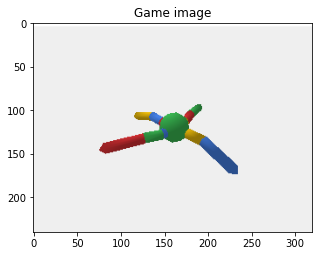

In [9]:
env.reset()
for _ in range(12):
    obs, r, _, info = env.step([env.action_space.sample() for _ in range(8)])

plt.figure(figsize=[5,5])
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

# Network

In [10]:
BipedalWalkerNN = lambda input_size, output_size: nn.Sequential(
    nn.Linear(input_size, 128),
    nn.Tanh(),
    nn.Linear(128, 128),
    nn.Tanh(),
    nn.Linear(128, output_size)
)

# Twin Delayed DDPG

In [11]:
class Critic(RLmodule):
    def __init__(self, par):
        super().__init__(par)
        
        self.q_network      = ForwardQNetwork(self, BipedalWalkerNN)
        self.target_network = Frozen(self, self.q_network, SoftUpdate())
        self.loss           = CriticLoss(self)
        self.trainer        = Trainer(self, models=self.q_network,
                                    optimizer_args={"lr": 0.0001, "eps": 1e-5}, clip_gradients=10)
        
    def train(self, batch, target):
        prediction = self.q_network.Q(batch.states, batch.actions)
        loss = self.loss(prediction, target)
        self.trainer.optimize(loss)
        
        self.target_network.update()

In [12]:
class Actor(RLmodule):
    def __init__(self, par, K = 2):
        super().__init__(par)
        
        self.K = K
        
        self.policy         = PolicyNetwork(self, BipedalWalkerNN, output=DeterministicPolicy)        
        self.target_policy  = Frozen(self, self.policy, SoftUpdate())     
        self.clipped_noise  = ClippedNoise(self)
        self.policy_loss    = DeterministicActorLoss(self)
        self.actor_trainer  = Trainer(self, models=self.policy,
                                    optimizer_args={"lr": 0.0001, "eps": 1e-5}, clip_gradients=10)
        
    def train(self, batch, critic):
        if self.system.iterations % self.K == 0:
            new_actions = self.policy(batch.states).rsample()
            V = critic(batch.states, new_actions)
            loss = self.policy_loss(V)
            self.actor_trainer.optimize(loss)
        
        self.target_policy.update()
        
    def target_act(self, next_states):
        with torch.no_grad():
            next_actions = self.target_policy(next_states).sample()
            return self.clipped_noise(next_actions)
            
    def hyperparameters(self):
        hp = super().hyperparameters()
        hp.update({"DelayedPolicyTraining": self.K})
        return hp

In [13]:
from LegoRL.models.frozen import SoftUpdate

class TD3(System):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs, already_vectorized=True)
        
        self.runner         = Runner(self)
        self.noise          = OUnoise(self)
        self.actor          = Actor(self)          
        self.critic1        = Critic(self)       
        self.critic2        = Critic(self) 
        self.twin           = Twin(self)
        self.replay         = ReplayBuffer(self, capacity=100000)
        self.sampler        = Sampler(self, self.replay, batch_size=64, cold_start=1000)        
        
    def target(self, batch):
        with torch.no_grad():
            # Creating target for critic
            next_actions = self.actor.target_act(batch.next_states)
            next_V1 = self.critic1.target_network(batch.next_states, next_actions)
            next_V2 = self.critic2.target_network(batch.next_states, next_actions)
            return self.twin(next_V1, next_V2).one_step(batch.rewards, batch.discounts)
    
    def iteration(self):
        # Data collection---------------------------------------------------------------
        if self.system.iterations % 8 == 0:
            with torch.no_grad():
                actions = self.actor.policy(self.runner.states).sample()
                actions = self.noise(actions, self.runner.is_start)

                transition = self.runner.step(actions)
                self.replay.store(transition)
        
        # Training ---------------------------------------------------------------------
        batch = self.sampler.sample()
        if batch:
            # Actor
            self.actor.train(batch, self.critic1.q_network)

            # Critic 1
            target = self.target(batch)            
            self.critic1.train(batch, target)
        
        # Critic 2; other batch
        batch = self.sampler.sample()
        if batch:
            target = self.target(batch)            
            self.critic2.train(batch, target)

In [14]:
td3        = TD3(gamma=0.99, folder_name="models/Ant TD3", save_timer=10000, env=env)
#player     = Player(td3, policy=td3.actor.policy.act, timer=10000, record_timer=40000)
visualizer = Visualizer(td3, timer=4000)

Initializing <PolicyNetwork>:
  Input shape is torch.Size([28])
  Output shape is torch.Size([8])
Initializing <ForwardQNetwork>:
  Input shapes:
    torch.Size([28])
    torch.Size([8])
  Output shape is torch.Size([])
Initializing <ForwardQNetwork>:
  Input shapes:
    torch.Size([28])
    torch.Size([8])
  Output shape is torch.Size([])


In [15]:
td3

<Runner>: Makes steps in 8 parallel environments
<OUnoise>: Adds Ornstein–Uhlenbeck noise to actions
<Actor>:
    <Actor.PolicyNetwork>: Models Deterministic Policy
    <Actor.FrozenModule>: Frozen copy of <Actor.PolicyNetwork>
    <Actor.ClippedNoise>: Adds clipped noise to actions
    <Actor.DeterministicActorLoss>: Calculates deterministic policy loss
    <Actor.Trainer>: Standard SGD loss optimization
    
<Critic>:
    <Critic.ForwardQNetwork>: Models V-function
    <Critic.FrozenModule>: Frozen copy of <Critic.ForwardQNetwork>
    <Critic.CriticLoss>: Calculates TD loss
    <Critic.Trainer>: Standard SGD loss optimization
    
<Critic2>:
    <Critic2.ForwardQNetwork>: Models V-function
    <Critic2.FrozenModule>: Frozen copy of <Critic2.ForwardQNetwork>
    <Critic2.CriticLoss>: Calculates TD loss
    <Critic2.Trainer>: Standard SGD loss optimization
    
<Twin>: Ensembles two value functions by taking minimum
<ReplayBuffer>: Stores data in raw numpy format
<Sampler>: Samples min

In [16]:
td3.hyperparameters()

{'Runner': {'num_envs': 8},
 'OUnoise': {'OU_theta': 0.15, 'OU_sigma': 0.2},
 'Actor': {'Actor.FrozenModule': {'tau': 0.01},
  'Actor.ClippedNoise': {'cliprange': 0.2, 'sigma': 0.2},
  'Actor.DeterministicActorLoss': {'weight': 1},
  'Actor.Trainer': {'clip_gradients': 10,
   'optimizer': 'Adam',
   'optimizer lr': 0.0001,
   'optimizer eps': 1e-05},
  'DelayedPolicyTraining': 2},
 'Critic': {'Critic.FrozenModule': {'tau': 0.01},
  'Critic.CriticLoss': {'weight': 1},
  'Critic.Trainer': {'clip_gradients': 10,
   'optimizer': 'Adam',
   'optimizer lr': 0.0001,
   'optimizer eps': 1e-05}},
 'Critic2': {'Critic2.FrozenModule': {'tau': 0.01},
  'Critic2.CriticLoss': {'weight': 1},
  'Critic2.Trainer': {'clip_gradients': 10,
   'optimizer': 'Adam',
   'optimizer lr': 0.0001,
   'optimizer eps': 1e-05}},
 'ReplayBuffer': {'capacity': 100000},
 'Sampler': {'batch_size': 64, 'cold_start': 1000},
 'gamma': 0.99}

In [19]:
td3.load()

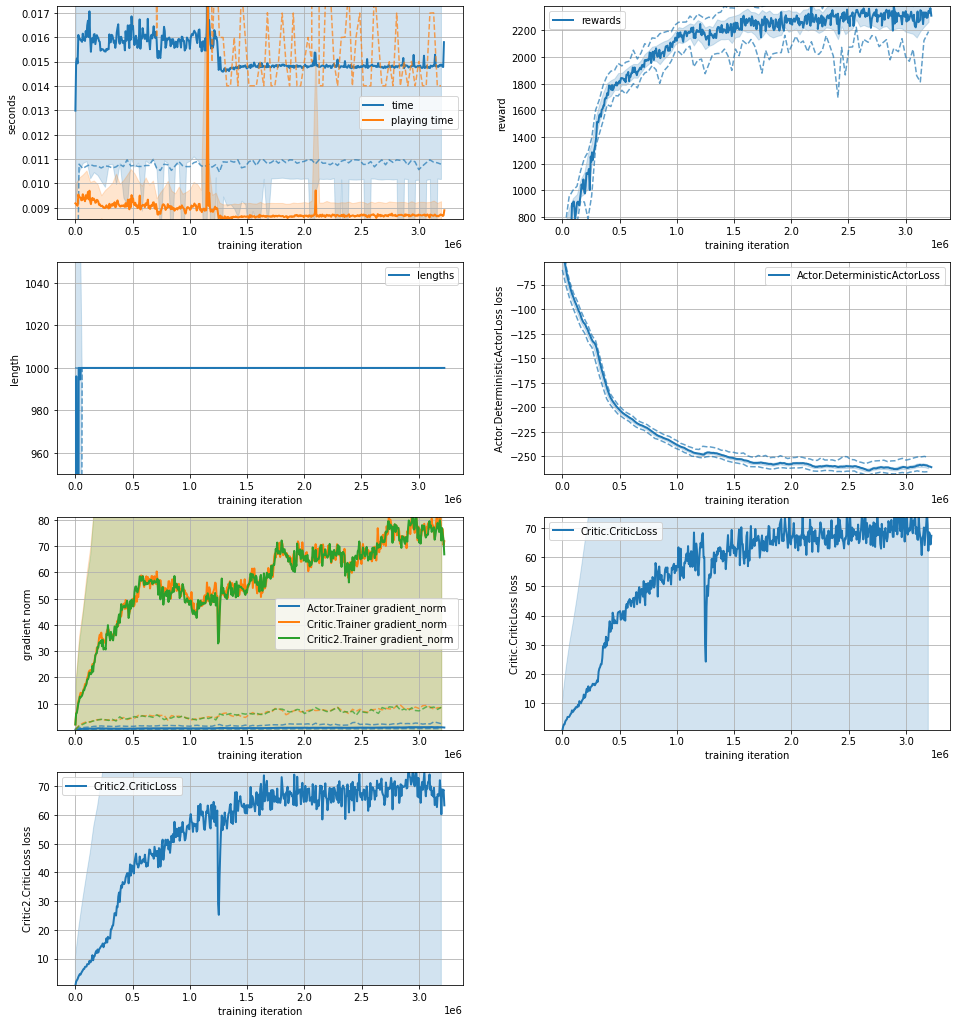

KeyboardInterrupt: 

In [20]:
td3.run(10000000)

# What we learned

In [21]:
rollout = td3.runner.play(policy=td3.actor.policy.act, store_frames=True, time_limit=2000)

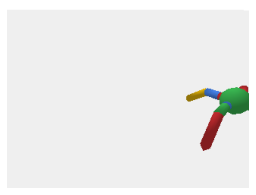

In [25]:
# shows animation of recorded game
html = show_animation(rollout.frames)

In [28]:
import imageio
imageio.mimwrite("results/ant.mp4", rollout["frames"])

# Training statistics

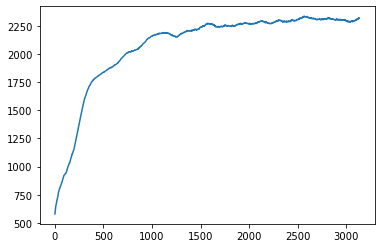

In [23]:
from LegoRL.utils.visualizer import smoothen
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(smoothen(td3.logger["rewards"], 100))

In [24]:
print("Learning time in hours: ", td3.wallclock() / 60 / 60)
print("Viz. time in hours: ", td3.viz_wallclock() / 60 / 60)
print("Frames done: ", td3.runner.frames_done)
print("Fps: ", td3.runner.fps)
print("Episodes played: ", td3.runner.episodes_done)

Learning time in hours:  13.673540145224996
Viz. time in hours:  2.521149795916345
Frames done:  1979504
Fps:  40.213596214455286
Episodes played:  1976
